In [1]:
if 'google.colab' in str(get_ipython()):
  !pip install -q condacolab
  import condacolab
  condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:29
🔁 Restarting kernel...


In [ ]:
%%capture
if 'google.colab' in str(get_ipython()):
  ! conda install -c conda-forge pynini=2.1.3

In [2]:
import string
import pynini
from pynini import Far
from pynini.export import export
from pynini.examples import plurals
from pynini.lib import byte, pynutil, utf8
NEMO_CHAR = utf8.VALID_UTF8_CHAR
NEMO_DIGIT = byte.DIGIT
NEMO_LOWER = pynini.union(*string.ascii_lowercase).optimize()
NEMO_UPPER = pynini.union(*string.ascii_uppercase).optimize()
NEMO_ALPHA = pynini.union(NEMO_LOWER, NEMO_UPPER).optimize()
NEMO_ALNUM = pynini.union(NEMO_DIGIT, NEMO_ALPHA).optimize()
NEMO_SIGMA = pynini.closure(NEMO_CHAR)
NEMO_SPACE = " "
NEMO_WHITE_SPACE = pynini.union(" ", "\t", "\n", "\r", u"\u00A0").optimize()
delete_space = pynutil.delete(pynini.closure(NEMO_WHITE_SPACE))
insert_space = pynutil.insert(" ")


In [3]:
from pathlib import Path
import os

In [4]:
class GraphFst:
    """
    Base class for all grammar fsts.

    Args:
        name: name of grammar class
        kind: either 'classify' or 'verbalize'
        deterministic: if True will provide a single transduction option,
            for False multiple transduction are generated (used for audio-based normalization)
    """

    def __init__(self, name: str, kind: str, deterministic: bool = True):
        self.name = name
        self.kind = str
        self._fst = None
        self.deterministic = deterministic

        self.far_path = Path(os.path.dirname(__file__) + '/grammars/' + kind + '/' + name + '.far')
        if self.far_exist():
            self._fst = Far(self.far_path, mode="r", arc_type="standard", far_type="default").get_fst()

    def far_exist(self) -> bool:
        """
        Returns true if FAR can be loaded
        """
        return self.far_path.exists()

    @property
    def fst(self) -> 'pynini.FstLike':
        return self._fst

    @fst.setter
    def fst(self, fst):
        self._fst = fst

    def add_tokens(self, fst) -> 'pynini.FstLike':
        """
        Wraps class name around to given fst

        Args:
            fst: input fst

        Returns:
            Fst: fst
        """
        return pynutil.insert(f"{self.name} {{ ") + fst + pynutil.insert(" }")

    def delete_tokens(self, fst) -> 'pynini.FstLike':
        """
        Deletes class name wrap around output of given fst

        Args:
            fst: input fst

        Returns:
            Fst: fst
        """
        res = (
            pynutil.delete(f"{self.name}")
            + delete_space
            + pynutil.delete("{")
            + delete_space
            + fst
            + delete_space
            + pynutil.delete("}")
        )
        return res @ pynini.cdrewrite(pynini.cross(u"\u00A0", " "), "", "", NEMO_SIGMA)


In [5]:
!mkdir -p data/numbers/

In [6]:
%%writefile data/numbers/zero.tsv
noll	0

Writing data/numbers/zero.tsv


In [7]:
%%writefile data/numbers/ties.tsv
tjugo	2
trettio	3
fyrtio	4
femtio	5
sextio	6
sjuttio	7
åttio	8
nittio	9

Writing data/numbers/ties.tsv


In [8]:
%%writefile data/numbers/digit.tsv
ett	1
två	2
tre	3
fyra	4
fem	5
sex	6
sju	7
åtta	8
nio	9

Writing data/numbers/digit.tsv


In [9]:
%%writefile data/numbers/teen.tsv
tio	10
elva	11
tolv	12
tretton	13
fjorton	14
femton	15
sexton	16
sjutton	17
arton	18
nitton	19

Writing data/numbers/teen.tsv


In [10]:
def get_abs_path(rel_path):
    """
    Get absolute path

    Args:
        rel_path: relative path to this file
        
    Returns absolute path
    """
    abs_path = "/content" + os.sep + rel_path

    if not os.path.exists(abs_path):
        print(f'{abs_path} does not exist')
    return abs_path


In [11]:
zero = pynini.invert(pynini.string_file(get_abs_path("data/numbers/zero.tsv")))
digit = pynini.invert(pynini.string_file(get_abs_path("data/numbers/digit.tsv")))
teen = pynini.invert(pynini.string_file(get_abs_path("data/numbers/teen.tsv")))
ties = pynini.invert(pynini.string_file(get_abs_path("data/numbers/ties.tsv")))


In [12]:
def filter_punctuation(fst):
    exactly_three_digits = NEMO_DIGIT ** 3  # for blocks of three
    up_to_three_digits = pynini.closure(NEMO_DIGIT, 1, 3)  # for start of string

    cardinal_separator = NEMO_SPACE
    cardinal_string = pynini.closure(
        NEMO_DIGIT, 1
    )  # For string w/o punctuation (used for page numbers, thousand series)

    cardinal_string |= (
        up_to_three_digits
        + pynutil.delete(cardinal_separator)
        + pynini.closure(exactly_three_digits + pynutil.delete(cardinal_separator))
        + exactly_three_digits
    )

    return cardinal_string @ fst


In [13]:
deterministic = False

In [14]:
graph_digit = digit
digits_no_one = (NEMO_DIGIT - "1") @ graph_digit
both_ones = (pynini.cross("1", "en") | pynini.cross("1", "ett"))
if deterministic:
    final_digit = digit
else:
    final_digit = digits_no_one | both_ones


In [15]:
graph_tens = teen
if deterministic:
    graph_tens |= ties + (pynutil.delete('0') | graph_digit)
    final_tens = graph_tens
else:
    graph_tens |= ties + (pynutil.delete('0') | (graph_digit | pynutil.insert(' ') + graph_digit))
    final_tens = graph_tens
    final_tens |= ties + (pynutil.delete('0') | (final_digit | pynutil.insert(' ') + final_digit))


In [16]:
graph_digit = digit
digits_no_one = (NEMO_DIGIT - "1") @ graph_digit
both_ones = (pynini.cross("1", "en") | pynini.cross("1", "ett"))
if deterministic:
    final_digit = digit
else:
    final_digit = digits_no_one | both_ones

# Any double digit
graph_tens = teen
if deterministic:
    graph_tens |= ties + (pynutil.delete('0') | graph_digit)
    final_tens = graph_tens
else:
    graph_tens |= ties + (pynutil.delete('0') | (graph_digit | pynutil.insert(' ') + graph_digit))
    final_tens |= ties + (pynutil.delete('0') | (final_digit | pynutil.insert(' ') + final_digit))

hundreds = digits_no_one + pynutil.insert("hundra")
hundreds |= pynini.cross("1", "hundra")
if not deterministic:
    hundreds |= pynini.cross("1", "etthundra")
    hundreds |= digit + pynutil.insert(NEMO_SPACE) + pynutil.insert("hundra")

self_tens = graph_tens.optimize()

graph_two_digit_non_zero = pynini.union(
    graph_digit, graph_tens, (pynutil.delete("0") + graph_digit)
)
if not deterministic:
    graph_two_digit_non_zero |= pynini.union(
        graph_digit, graph_tens, (pynini.cross("0", NEMO_SPACE) + graph_digit)
    )

self_two_digit_non_zero = graph_two_digit_non_zero.optimize()

graph_final_two_digit_non_zero = pynini.union(
    final_digit, graph_tens, (pynutil.delete("0") + final_digit)
)
if not deterministic:
    graph_final_two_digit_non_zero |= pynini.union(
        final_digit, graph_tens, (pynini.cross("0", NEMO_SPACE) + final_digit)
    )

self_final_two_digit_non_zero = graph_final_two_digit_non_zero.optimize()

# Three digit strings
graph_hundreds = hundreds + pynini.union(
    pynutil.delete("00"), graph_tens, (pynutil.delete("0") + final_digit)
)
if not deterministic:
    graph_hundreds |= hundreds + pynini.union(
        pynutil.delete("00"), (graph_tens | pynutil.insert(NEMO_SPACE) + graph_tens), (pynini.cross("0", NEMO_SPACE) + final_digit)
    )

self_hundreds = graph_hundreds.optimize()

graph_hundreds_component = pynini.union(graph_hundreds, pynutil.delete("0") + graph_tens)

graph_hundreds_component_at_least_one_non_zero_digit = graph_hundreds_component | (
    pynutil.delete("00") + graph_digit
)
graph_hundreds_component_at_least_one_non_zero_digit_no_one = graph_hundreds_component | (
    pynutil.delete("00") + digits_no_one
)


tusen = pynutil.insert("tusen")
if not deterministic:
    tusen |= pynutil.insert(" tusen")

graph_thousands_component_at_least_one_non_zero_digit = pynini.union(
    pynutil.delete("000") + graph_hundreds_component_at_least_one_non_zero_digit,
    graph_hundreds_component_at_least_one_non_zero_digit_no_one
    + tusen
    + ((insert_space + graph_hundreds_component_at_least_one_non_zero_digit) | pynutil.delete("000")),
    pynini.cross("001", "tusen")
    + ((insert_space + graph_hundreds_component_at_least_one_non_zero_digit) | pynutil.delete("000")),
)

graph_thousands_component_at_least_one_non_zero_digit_no_one = pynini.union(
    pynutil.delete("000") + graph_hundreds_component_at_least_one_non_zero_digit_no_one,
    graph_hundreds_component_at_least_one_non_zero_digit_no_one
    + tusen
    + ((insert_space + graph_hundreds_component_at_least_one_non_zero_digit) | pynutil.delete("000")),
    pynini.cross("001", "tusen")
    + ((insert_space + graph_hundreds_component_at_least_one_non_zero_digit) | pynutil.delete("000")),
)



In [32]:
("hundraett" @ pynini.invert(graph_hundreds_component_at_least_one_non_zero_digit_no_one).optimize()).string()

'101'

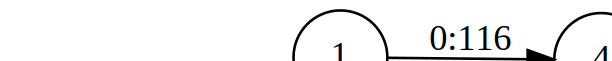

In [39]:
("101" @ graph_hundreds_component_at_least_one_non_zero_digit_no_one)

In [35]:
def run_norm(text, graph=graph_hundreds_component_at_least_one_non_zero_digit_no_one, invert=False):
    if invert:
        cur_graph = pynini.invert(graph).optimize()
    else:
        cur_graph = graph.optimize()
    return (text @ cur_graph).optimize().string()

In [36]:
run_norm("101", invert=False)

FstOpError: ignored

In [86]:
("9" @ hundreds).string()

'niohundra'

In [91]:
graph_hundreds = hundreds + pynini.union(
    pynutil.delete("00"), graph_tens, (pynutil.delete("0") + graph_digit)
)


In [40]:
_VOWEL_LOWER = pynini.union("a", "e", "i", "o", "u", "á", "é", "í", "ó", "ú")
_VOWEL_UPPER = pynini.union("A", "E", "I", "O", "U", "Á", "É", "Í", "Ó", "Ú")


In [60]:
UPPER_ECLIPSIS_LETTERS = pynini.union(
    pynini.cross("B", "mB"),
    pynini.cross("C", "gC"),
    pynini.cross("D", "nD"),
    pynini.cross("F", "bhF"),
    pynini.cross("G", "nG"),
    pynini.cross("P", "bP"),
    pynini.cross("T", "dT"),
    pynini.cross("A", "nA"),
    pynini.cross("E", "nE"),
    pynini.cross("I", "nI"),
    pynini.cross("O", "nO"),
    pynini.cross("U", "nU"),
    pynini.cross("Á", "nÁ"),
    pynini.cross("É", "nÉ"),
    pynini.cross("Í", "nÍ"),
    pynini.cross("Ó", "nÓ"),
    pynini.cross("Ú", "nÚ"),
)
UPPER_ECLIPSIS = pynini.cdrewrite(UPPER_ECLIPSIS_LETTERS, "[BOS]", "", NEMO_SIGMA)

In [66]:
CHAR_NO_H = NEMO_CHAR - pynini.union("h", "H")
TITLE_LENITION_LETTERS = pynini.union(
    pynini.cross("B", "Bh"),
    pynini.cross("C", "Ch"),
    pynini.cross("D", "Dh"),
    pynini.cross("F", "Fh"),
    pynini.cross("G", "Gh"),
    pynini.cross("M", "Mh"),
    pynini.cross("P", "Ph"),
    pynini.cross("S", "Sh"),
    pynini.cross("T", "Th")
)
TITLE_LENITION = pynini.cdrewrite(TITLE_LENITION_LETTERS, "[BOS]", CHAR_NO_H, NEMO_SIGMA)

In [73]:
("d'osc" @ TITLE_LENITION).string()

"d'osc"

In [45]:
SIGMA_NO_H = NEMO_SIGMA - pynini.union("h", "H")

In [74]:
UPPER_VOWELS = pynini.union("A", "E", "I", "O", "U", "Á", "É", "Í", "Ó", "Ú").optimize()
LOWER_VOWELS = pynini.union("a", "e", "i", "o", "u", "á", "é", "í", "ó", "ú").optimize()
UPPER_PONC = pynini.union("Ḃ", "Ċ", "Ḋ", "Ḟ", "Ġ", "Ṁ", "Ṗ", "Ṡ", "Ṫ").optimize()
LOWER_PONC = pynini.union("ḃ", "ċ", "ḋ", "ḟ", "ġ", "ṁ", "ṗ", "ṡ", "ṫ").optimize()
BASE_UPPER = pynini.union(NEMO_UPPER, UPPER_VOWELS).optimize()
BASE_LOWER = pynini.union(NEMO_LOWER, LOWER_VOWELS).optimize()


In [75]:
UPPER_CONS = (BASE_UPPER - UPPER_VOWELS)

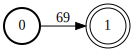

In [85]:
(u"E" @ UPPER_VOWELS)

In [86]:
TO_LOWER = pynini.union(*[pynini.cross(x, y) for x, y in zip(string.ascii_uppercase, string.ascii_lowercase)])

In [87]:
_FADA_LOWER = pynini.union(*[pynini.cross(x, y) for x, y in zip(
    ["Á", "É", "Í", "Ó", "Ú"], ["á", "é", "í", "ó", "ú"])]
)
_PONC_LOWER = pynini.union(*[pynini.cross(x, y) for x, y in zip(
    ["Ḃ", "Ċ", "Ḋ", "Ḟ", "Ġ", "Ṁ", "Ṗ", "Ṡ", "Ṫ"], ["ḃ", "ċ", "ḋ", "ḟ", "ġ", "ṁ", "ṗ", "ṡ", "ṫ"])]
)

GA_LOWER = pynini.union(TO_LOWER, _FADA_LOWER, _PONC_LOWER)


In [117]:
_LOWERCASE_STARTS = pynini.union(
    pynini.cross("nA", "n-a"),
    pynini.cross("nE", "n-e"),
    pynini.cross("nI", "n-i"),
    pynini.cross("nO", "n-o"),
    pynini.cross("nU", "n-u"),
    pynini.cross("nÁ", "n-á"),
    pynini.cross("nÉ", "n-é"),
    pynini.cross("nÍ", "n-í"),
    pynini.cross("nÓ", "n-ó"),
    pynini.cross("nÚ", "n-ú"),
    pynini.cross("tA", "t-a"),
    pynini.cross("tE", "t-e"),
    pynini.cross("tI", "t-i"),
    pynini.cross("tO", "t-o"),
    pynini.cross("tU", "t-u"),
    pynini.cross("tÁ", "t-á"),
    pynini.cross("tÉ", "t-é"),
    pynini.cross("tÍ", "t-í"),
    pynini.cross("tÓ", "t-ó"),
    pynini.cross("tÚ", "t-ú")
)
_DO_LOWER_STARTS = pynini.cdrewrite(_LOWERCASE_STARTS, "[BOS]", "", NEMO_SIGMA)
TOLOWER = (_DO_LOWER_STARTS @ pynini.closure(GA_LOWER | BASE_LOWER | "'" | "-")).optimize()


In [119]:
("tASAL" @ TOLOWER).string()

't-asal'